In [21]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [22]:
def load_data(company, start, end):
    data = web.DataReader(company, 'yahoo', start, end)
    return data

In [23]:
company = 'FB'

In [24]:
data = load_data(company = company,
                 start = dt.datetime(2012,1,1),
                 end = dt.datetime(2019,1,1))

In [25]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [26]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [27]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

In [28]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [29]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=25, 
          batch_size = 32,
          callbacks = [checkpointer])

Epoch 1/25
51/51 [==============================] - 9s 94ms/step - loss: 0.0209
Epoch 2/25
51/51 [==============================] - 5s 96ms/step - loss: 0.0034
Epoch 3/25
51/51 [==============================] - 5s 93ms/step - loss: 0.0031
Epoch 4/25
51/51 [==============================] - 5s 95ms/step - loss: 0.0036
Epoch 5/25
51/51 [==============================] - 5s 95ms/step - loss: 0.0030
Epoch 6/25
51/51 [==============================] - 5s 96ms/step - loss: 0.0026
Epoch 7/25
51/51 [==============================] - 5s 95ms/step - loss: 0.0026
Epoch 8/25
51/51 [==============================] - 5s 95ms/step - loss: 0.0026
Epoch 9/25
51/51 [==============================] - 5s 95ms/step - loss: 0.0022
Epoch 10/25
51/51 [==============================] - 5s 94ms/step - loss: 0.0024
Epoch 11/25
51/51 [==============================] - 5s 94ms/step - loss: 0.0025
Epoch 12/25
51/51 [==============================] - 5s 93ms/step - loss: 0.0023
Epoch 13/25
51/51 [==================

# Prediction

In [31]:
test_data = load_data(company = 'Fb',
                      start = dt.datetime(2019,1,1),
                      end = dt.datetime.now())

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [32]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

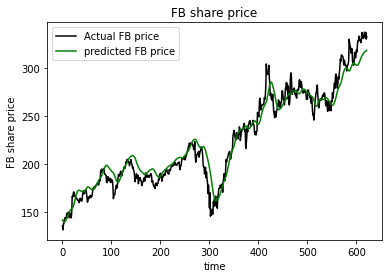

In [33]:
plt.plot(actual_prices, color='black', label=f"Actual {company} price")
plt.plot(predicted_prices, color= 'green', label=f"predicted {company} price")
plt.title(f"{company} share price")
plt.xlabel("time")
plt.ylabel(f"{company} share price")
plt.legend()
plt.show()

In [34]:
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [35]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction}")

prediction: [[318.05655]]
